**Name:** LI XINYAN

**EID:** 55670594

# CS5489 - Tutorial 9
## Face Detection with CNNs

In the previous tutorial, you used an MLP to detect a face in a small image patch.
In this tutorial you will train a CNN instead of an MLP.

First we need to initialize Python.  Run the below cell.

In [1]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import os
import zipfile
import fnmatch
random.seed(100)
import skimage.io
import skimage.color
import skimage.transform
from scipy import ndimage

Next we will load keras and tensorflow.

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
import struct
K.set_image_data_format('channels_last')
print(keras.__version__, tf.__version__)

2.2.4-tf 1.15.0


## 1. Loading Data and Pre-processing
Next we need to load the images.  Download `faces.zip`, and place it in the same directory as this ipynb file.  **Do not unzip it.** Then run the following cell to load the images.

In [3]:
imgdata = {'train':[], 'test':[]}
classes = {'train':[], 'test':[]}

# the dataset is too big, so subsample the training and test sets...
# reduce training set by a factor of 4
train_subsample = 1
train_counter = [0, 0]
# maximum number of samples in each class for test set
test_maxsample = 472
test_counter = [0, 0]

# load the zip file
filename = 'faces.zip'
zfile = zipfile.ZipFile(filename, 'r')

for name in zfile.namelist():
    # check file name matches
    if fnmatch.fnmatch(name, "faces/*/*/*.png"):
        
        # filename is : faces/train/face/fname.png
        (fdir1, fname)  = os.path.split(name)     # get file name
        (fdir2, fclass) = os.path.split(fdir1) # get class (face, nonface)
        (fdir3, fset)   = os.path.split(fdir2) # get training/test set
        # class 1 = face; class 0 = non-face
        myclass = int(fclass == "face")  

        loadme = False
        if fset == 'train':
            if (train_counter[myclass] % train_subsample) == 0:
                loadme = True
            train_counter[myclass] += 1
        elif fset == 'test':
            if test_counter[myclass] < test_maxsample:
                loadme = True
            test_counter[myclass] += 1
            
        if (loadme):
            # open file in memory, and parse as an image
            myfile = zfile.open(name)
            #img = matplotlib.image.imread(myfile)
            img = skimage.io.imread(myfile)
            # convert to grayscale
            img = skimage.color.rgb2gray(img)
            myfile.close()
            
            # append data
            imgdata[fset].append(img)
            classes[fset].append(myclass)

        
zfile.close()
imgsize = img.shape

print(len(imgdata['train']))
print(len(imgdata['test']))
trainclass2start = sum(classes['train'])

6977
944


Next we will convert the list of images into a block (array) of images for easier processing.

In [4]:
# convert list to numpy array
trainY = asarray(classes['train'])
testY  = asarray(classes['test'])

# convert class labels to binary indicators
trainYb = keras.utils.to_categorical(trainY)
testYb  = keras.utils.to_categorical(testY)

# convert list of ndarray to ndarray
trainI = asarray(imgdata['train']).reshape((6977,19,19,1))
testI  = asarray(imgdata['test']).reshape((944,19,19,1))

# cleanup memory
del imgdata

# shuffle the data (since it is in order by class)
random.seed(123)
inds1 = random.permutation(len(trainI)).tolist()
inds2 = random.permutation(len(testI)).tolist()
trainYb = trainYb[inds1]
testYb  = testYb[inds2]
trainY = trainY[inds1]
testY  = testY[inds2]
trainI = trainI[inds1]
testI = testI[inds2]

print(trainI.shape)
print(testI.shape)

(6977, 19, 19, 1)
(944, 19, 19, 1)


Each image is a 19x19x1 array of pixel values.  The last dimension is the number of channels in the image - in this case the image is grayscale, so there is only 1 channel.  Run the below code to show an example:

(19, 19)


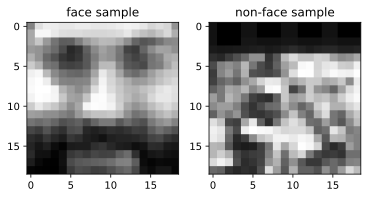

In [5]:
print(img.shape)
plt.subplot(1,2,1)
plt.imshow(squeeze(trainI[1]), cmap='gray', interpolation='nearest')
plt.title("face sample")
plt.subplot(1,2,2)
plt.imshow(squeeze(trainI[2]), cmap='gray', interpolation='nearest')
plt.title("non-face sample")
plt.show()

Run the below code to show more images!

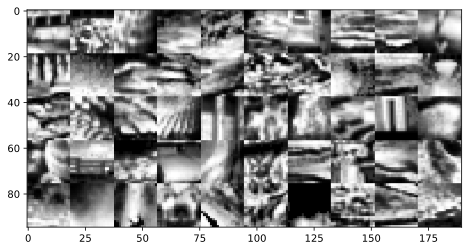

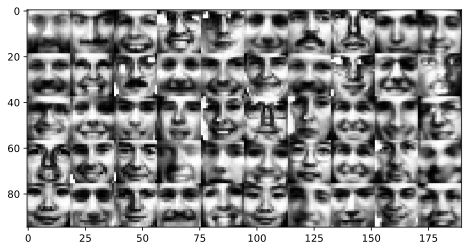

In [6]:
# function to make an image montage
def image_montage(X, imsize=None, maxw=10):
    """X can be a list of images, or a matrix of vectorized images.
      Specify imsize when X is a matrix."""
    tmp = []
    numimgs = len(X)
    
    # create a list of images (reshape if necessary)
    for i in range(0,numimgs):
        if imsize != None:
            tmp.append(X[i].reshape(imsize))
        else:
            tmp.append(squeeze(X[i]))
    
    # add blanks
    if (numimgs > maxw) and (mod(numimgs, maxw) > 0):
        leftover = maxw - mod(numimgs, maxw)
        meanimg = 0.5*(X[0].max()+X[0].min())
        for i in range(0,leftover):
            tmp.append(ones(tmp[0].shape)*meanimg)
    
    # make the montage
    tmp2 = []
    for i in range(0,len(tmp),maxw):
        tmp2.append( hstack(tmp[i:i+maxw]) )
    montimg = vstack(tmp2) 
    return montimg

# show images in a plot
def show_imgs(W_list, nc=10, highlight_green=None, highlight_red=None, titles=None):
    # nc is the number of columns
    nfilter = len(W_list)
    nr = (nfilter - 1) // nc + 1
    for i in range(nr):
        for j in range(nc):
            idx = i * nc + j
            if idx == nfilter:
                break
            plt.subplot(nr, nc, idx + 1)
            cur_W = W_list[idx]
            plt.imshow(cur_W,cmap='gray', interpolation='nearest')  
            if titles is not None:
                if isinstance(titles, str):
                    plt.title(titles.format(idx))
                else:
                    plt.title(titles[idx])
            
            if ((highlight_green is not None) and highlight_green[idx]) or \
               ((highlight_red is not None) and highlight_red[idx]): 
                ax = plt.gca()
                if highlight_green[idx]:
                    mycol = '#00FF00'
                else:
                    mycol = 'r'
                for S in ['bottom', 'top', 'right', 'left']:
                    ax.spines[S].set_color(mycol)
                    ax.spines[S].set_lw(2.0)
                ax.xaxis.set_ticks_position('none')               
                ax.yaxis.set_ticks_position('none')
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                plt.gca().set_axis_off()

# show a few images
plt.figure(figsize=(9,4))
plt.imshow(image_montage(trainI[trainYb[:,0]==1][0:50]), cmap='gray', interpolation='nearest')
plt.show()

plt.figure(figsize=(9,4))
plt.imshow(image_montage(trainI[trainYb[:,1]==1][0:50]), cmap='gray', interpolation='nearest')
plt.show()

Next we will generate the training/validation set from the training data.

In [7]:
# generate fixed validation set of 10% of the training set
vtrainI, validI, vtrainYb, validYb = \
  model_selection.train_test_split(trainI, trainYb, 
  train_size=0.9, test_size=0.1, random_state=4488)

# make validation data
validsetI = (validI, validYb)

print(vtrainI.shape)
print(validI.shape)

(6279, 19, 19, 1)
(698, 19, 19, 1)


Here are some useful functions.

In [8]:
# compatible with v1 or v2
def tf_compat():
    if tf.__version__[0] == '1':
        return (tf.set_random_seed, 'acc')
    else:
        return (tf.random.set_seed, 'accuracy')
    
tf_set_seed, accname = tf_compat()

def plot_history(history): 
    fig, ax1 = plt.subplots()
    
    ax1.plot(history.history['loss'], 'r', label="training loss ({:.6f})".format(history.history['loss'][-1]))
    ax1.plot(history.history['val_loss'], 'r--', label="validation loss ({:.6f})".format(history.history['val_loss'][-1]))
    ax1.grid(True)
    ax1.set_xlabel('iteration')
    ax1.legend(loc="best", fontsize=9)    
    ax1.set_ylabel('loss', color='r')
    ax1.tick_params('y', colors='r')

    if accname in history.history:
        ax2 = ax1.twinx()

        ax2.plot(history.history[accname], 'b', label="training acc ({:.4f})".format(history.history[accname][-1]))
        ax2.plot(history.history['val_'+accname], 'b--', label="validation acc ({:.4f})".format(history.history['val_'+accname][-1]))

        ax2.legend(loc="best", fontsize=9)
        ax2.set_ylabel('acc', color='b')        
        ax2.tick_params('y', colors='b')

Now let's try a simple logistic regression classifier, trained using Keras. Since the inputs are images, we will convert the input image into a vector using the "Flatten" layer first.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Epoch 00013: early stopping
test accuracy: 0.5603813559322034


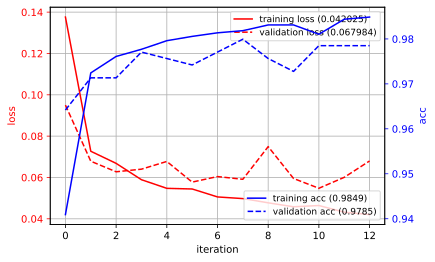

In [9]:
# initialize random seed
K.clear_session()
random.seed(4487); tf_set_seed(4487)

# build the network for logistic regression
nn = Sequential()
nn.add(Flatten(input_shape=(19,19,1)))        # vectorize the input image
nn.add(Dense(units=2, activation='softmax'))  # classification layer (2 classes)

# early stopping criteria
earlystop = keras.callbacks.EarlyStopping(
               monitor='val_'+accname,             # use validation accuracy for stopping
               min_delta=0.0001, patience=5, 
               verbose=1, mode='auto')
callbacks_list = [earlystop]

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.05, momentum=0.9, nesterov=True), 
           metrics=['accuracy']  # also calculate accuracy during training
          )

history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=50, 
                 callbacks=callbacks_list, 
                 validation_data=validsetI,  # specify the validation set
                 verbose=False)

plot_history(history)
predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

## 2. Detection using CNN

Train an CNN to classify an image patch as face or not face.  Use  `vtrainI` and `vtrainY` as the training set and `validsetI` as the validation set.  You can try different architectures, and adjust values of the learning rates, number of iterations, early stopping, regularization, etc. to get a good result.  Use a large batch size (e.g., 50) to speed up the training time.  Remember to add the `callbacks` so that you can monitor the training process.

In [10]:
random.seed(4487)
tf.set_random_seed(4487)

### MLP in Tutorial 8

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 361)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               185344    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 317,186
Trainable params: 317,186
Non-trainable params: 0
_________________________________________________________________
Epoch 00030: early stopping
test accuracy: 0.7203389830508474


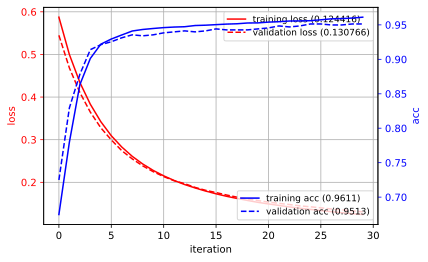

In [11]:
K.clear_session()

nn = Sequential()
nn.add(Flatten(input_shape=(19,19,1)))        # input layer flatterning
nn.add(Dense(units=512, input_dim=361, activation='relu')) # hidden layer 1
nn.add(Dense(units=256, input_dim=361, activation='relu')) # hidden layer 2
nn.add(Dense(units=2, activation='softmax')) # output layer

nn.summary()

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy, 
           optimizer=keras.optimizers.SGD(lr=0.001, momentum=0, nesterov=True),
           metrics=['accuracy'])

history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=64,
                 callbacks=callbacks_list,validation_data=validsetI, verbose=False)


plot_history(history)
predY = nn.predict_classes(testI, verbose=False) 
acc = metrics.accuracy_score(testY, predY) 
print("test accuracy:", acc)

### Architecture 1: 6-layer CNN model

In [12]:
nn = Sequential()
nn.add(Conv2D(10, (5,5), strides=(2,2), activation='relu', padding='same', input_shape=(19,19,1)))
nn.add(Conv2D(40, (5,5), strides=(2,2), activation='relu', padding='same'))
nn.add(Conv2D(80, (5,5), strides=(1,1), activation='relu', padding='same'))
nn.add(Flatten())
nn.add(Dense(units=50, activation='relu'))
nn.add(Dense(units=2, activation='softmax'))

nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 10, 10, 10)        260       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 40)          10040     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 80)          80080     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                100050    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 102       
Total params: 190,532
Trainable params: 190,532
Non-trainable params: 0
________________________________________________

In [13]:
# lr=1e-2, momentum=0.0, acc = 0.643
# lr=1e-2, momentum=0.1, acc = 0.648
# lr=1e-2, momentum=0.9, acc = 0.603
# lr=1e-3, momentum=0.1, acc = 0.647

# Early stopping callback function
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, mode='auto')

callbacks_list = [earlystop]
nn.compile(loss=keras.losses.categorical_crossentropy, 
           optimizer=keras.optimizers.SGD(lr=1e-2, momentum=0.1, nesterov=True), metrics=['accuracy'])
                         
history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=64, callbacks=callbacks_list,
                 validation_data=validsetI, verbose=False)

Epoch 00079: early stopping


test accuracy: 0.6885593220338984


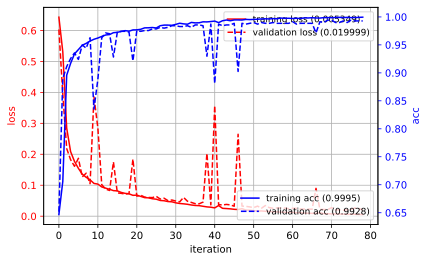

In [14]:
plot_history(history)
predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

### Architecture 2: 4-layer CNN model

In [15]:
nn = Sequential()
nn.add(Conv2D(10, (5,5),strides=(2,2), activation='relu', padding='same', input_shape=(19,19,1)))
nn.add(Flatten())
nn.add(Dense(units=50, activation='relu'))
nn.add(Dense(units=2, activation='softmax'))

nn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 10, 10, 10)        260       
_________________________________________________________________
flatten_2 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                50050     
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 102       
Total params: 50,412
Trainable params: 50,412
Non-trainable params: 0
_________________________________________________________________


In [16]:
# lr=1e-2, momentum=0.0, acc = 0.616
# lr=1e-2, momentum=0.1, acc = 0.599
# lr=1e-2, momentum=0.9, acc = 0.668
# lr=1e-3, momentum=0.9, acc = 0.617

# Early stopping callback function
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, mode='auto')

callbacks_list = [earlystop]
nn.compile(loss=keras.losses.categorical_crossentropy, 
           optimizer=keras.optimizers.SGD(lr=1e-2, momentum=0.9, nesterov=True), metrics=['accuracy'])
                         
history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=64, callbacks=callbacks_list,
                 validation_data=validsetI, verbose=False)

Epoch 00023: early stopping


test accuracy: 0.5084745762711864


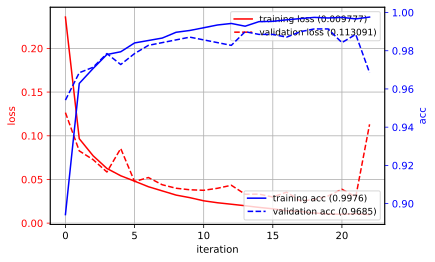

In [17]:
plot_history(history)
predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

### Architecture 3: 5-layer CNN model

In [18]:
nn = Sequential()
nn.add(Conv2D(10, (5,5),strides=(2,2), activation='relu', padding='same', input_shape=(19,19,1)))
nn.add(Conv2D(40, (5,5),strides=(2,2), activation='relu', padding='same'))
nn.add(Dropout(rate=0.5, seed=44))
nn.add(Flatten())
nn.add(Dense(units=50, activation='relu'))
nn.add(Dense(units=2, activation='softmax'))

nn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 10, 10, 10)        260       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 5, 40)          10040     
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 40)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                50050     
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 102       
Total params: 60,452
Trainable params: 60,452
Non-trainable params: 0
__________________________________________________

In [19]:
# lr=1e-2, momentum=0.0, acc = 0.628
# lr=1e-2, momentum=0.1, acc = 0.646
# lr=1e-2, momentum=0.9, acc = 0.683
# lr=1e-3, momentum=0.9, acc = 0.664

# Early stopping callback function
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, mode='auto')

callbacks_list = [earlystop]
nn.compile(loss=keras.losses.categorical_crossentropy, 
           optimizer=keras.optimizers.SGD(lr=1e-2, momentum=0.9, nesterov=True), metrics=['accuracy'])
                         
history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=64, callbacks=callbacks_list,
                 validation_data=validsetI, verbose=False)

Epoch 00034: early stopping


test accuracy: 0.635593220338983


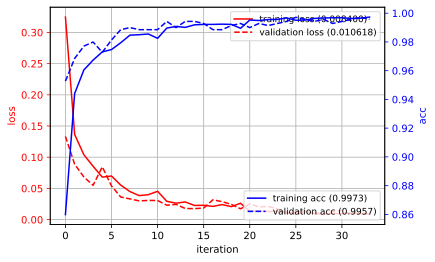

In [20]:
plot_history(history)
predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

### How does the CNN compare to the MLP that you tried in Tutorial 8?

1. In tutorial 8, I trained a 2-layer MLP with structure: (19,19,1) -> 512 -> 256 -> 2, and obtained test accuracy around  0.64 here. In tutorial 9, I trained a 5-layer CNN with structure: (19,19,1) -> (10,10,10) -> (5,5,40) -> 1000 -> 50 -> 2, and obtained test accuracy around  0.68 here.

2. Training the 5-layer CNN model is faster than training the 2-layer MLP model.

3. To achieve the same test accuracy, the 5-layer CNN model (60,452) needs fewer parametwers than the 2-layer MLP model (317,186).

4. In summarey, compared with MLP model, the CNN model can achieve higher accuracy with less parameters and less training time. I further tried using dropout in CNN model even though it did not improve much accuracy.

## 3. Data Augmentation

Now use data augmentation (introduced in the last tutorial) to try to improve the accuracy.

We can also add per-pixel noise or transformations. We define a few functions for adding per-pixel noise.  The following functions will add Gaussian pixel noise, add corruption noise (setting some input pixels to 0), scale and shift pixel values (changing contrast and brightness).

In [21]:
def add_gauss_noise(X, sigma2=0.05):
    # add Gaussian noise with zero mean, and variance sigma2
    return X + random.normal(0, sigma2, X.shape)

def add_corrupt_noise(X, p=0.1):
    # apply pixel corruption (zero out value) with probability p
    return X * random.binomial(1, 1-p, X.shape)

def add_scale_shift(X, sigma2=0.1, alpha2=0.2):
    # randomly scale and shift the pixel values (same for each image)
    # Xnew = a X + b
    # a is sampled from a Gaussian with mean 1, and variance sigma2
    # b is sampled from a Gaussian with mean 0, and variance alpha2
    if X.ndim == 3:
        dshape = (X.shape[0],1,1)
    elif X.ndim == 4:
        dshape = (X.shape[0],1,1,1)
    else:
        dshape = (1,)
    a = random.normal(1,sigma2, dshape)
    b = random.normal(0,alpha2, dshape)
    return minimum(maximum( a*X + b, 0.0), 1.0)

Next, we define a function for adding per-pixel noise (in this case just Gaussian noise). The noise is included using the `preprocessing_function` input of the `ImageDataGenerator`.

In [22]:
# build the noise function
def addNoise(X):
    return add_gauss_noise(X, 0.04)

# build the data augmenter
datagen = ImageDataGenerator(
    rotation_range=10,         # image rotation
    width_shift_range=0.05,     # image shifting
    height_shift_range=0.05,    # image shifting
    shear_range=0.05,           # shear transformation
    zoom_range=0.05,            # zooming
    horizontal_flip=True,       # horizontal flipping
    preprocessing_function=addNoise,  # add per-pixel noise
    data_format='channels_last')

Next we can show some examples of augmented images. Run the code below to see different random augmentations.

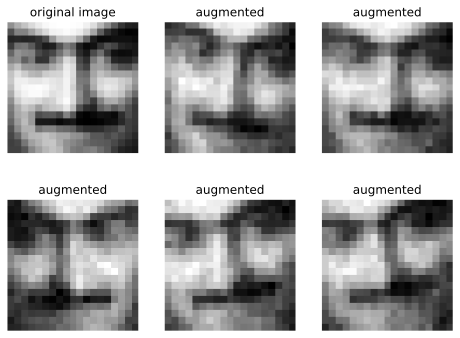

In [23]:
img = trainI[4]
imgs = [img[:,:,0]]

cnt = 0
for augimg, augy in datagen.flow(img.reshape(1,19,19,1), [1], batch_size=1):
    imgs.append(augimg[0,:,:,0])
    cnt += 1
    if cnt > 4:
        # we need to break the loop by hand because
        # the generator loops indefinitely
        break

titles = ['original image', 'augmented', 'augmented', 'augmented', 'augmented', 'augmented']
plt.figure(figsize=(8,6))
show_imgs(imgs, nc=3, titles=titles)

The augmented images look similar to the original image, but contain small differences that the network can use to learn more about the class.

Now let's try training logistic regression with data augmentation. Instead of "fit", we now  use the "fit_generator" method, which will pass each input through the ImageDataGenerator before sending it to the MLP.  We also disable early stopping so that the training sees more augmented data.

In [24]:
# initialize random seed
K.clear_session()
random.seed(4487); tf_set_seed(4487)

# build the network for logistic regression
nn = Sequential()
nn.add(Flatten(input_shape=(19,19,1)))        # vectorize the input image
nn.add(Dense(units=2, activation='softmax'))  # classification layer (2 classes)

# early stopping criteria
earlystop = keras.callbacks.EarlyStopping(
               monitor='val_'+accname,             # use validation accuracy for stopping
               min_delta=0.0001, patience=5, 
               verbose=1, mode='auto')
callbacks_list = [earlystop]

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.05, momentum=0.9, nesterov=True), 
           metrics=['accuracy']  # also calculate accuracy during training
          )

# fit with data generator
history = nn.fit_generator(
            datagen.flow(vtrainI, vtrainYb, batch_size=50),  # data from generator
            steps_per_epoch=len(vtrainI)/50,    # should be number of batches per epoch
            epochs=50,
#           callbacks=callbacks_list, 
            validation_data=validsetI, verbose=True)


Epoch 1/50
126/125 [==============================] - 2s 15ms/step - loss: 0.2362 - acc: 0.9073 - val_loss: 0.1543 - val_acc: 0.9427
Epoch 2/50
126/125 [==============================] - 2s 14ms/step - loss: 0.1757 - acc: 0.9314 - val_loss: 0.1494 - val_acc: 0.9370
Epoch 3/50
126/125 [==============================] - 2s 15ms/step - loss: 0.1769 - acc: 0.9285 - val_loss: 0.1897 - val_acc: 0.9140
Epoch 4/50
126/125 [==============================] - 2s 14ms/step - loss: 0.1670 - acc: 0.9323 - val_loss: 0.1223 - val_acc: 0.9499
Epoch 5/50
126/125 [==============================] - 2s 14ms/step - loss: 0.1717 - acc: 0.9339 - val_loss: 0.1436 - val_acc: 0.9341
Epoch 6/50
126/125 [==============================] - 2s 13ms/step - loss: 0.1654 - acc: 0.9345 - val_loss: 0.1621 - val_acc: 0.9284
Epoch 7/50
126/125 [==============================] - 2s 13ms/step - loss: 0.1667 - acc: 0.9315 - val_loss: 0.1050 - val_acc: 0.9599
Epoch 8/50
126/125 [==============================] - 2s 13ms/step - 

126/125 [==============================] - 2s 13ms/step - loss: 0.1590 - acc: 0.9382 - val_loss: 0.1708 - val_acc: 0.9255
Epoch 20/50
126/125 [==============================] - 2s 13ms/step - loss: 0.1674 - acc: 0.9355 - val_loss: 0.1020 - val_acc: 0.9556
Epoch 21/50
126/125 [==============================] - 2s 13ms/step - loss: 0.1519 - acc: 0.9412 - val_loss: 0.0936 - val_acc: 0.9599
Epoch 22/50
126/125 [==============================] - 2s 13ms/step - loss: 0.1511 - acc: 0.9416 - val_loss: 0.2454 - val_acc: 0.9054
Epoch 23/50
126/125 [==============================] - 2s 13ms/step - loss: 0.1588 - acc: 0.9379 - val_loss: 0.0923 - val_acc: 0.9628
Epoch 24/50
126/125 [==============================] - 2s 13ms/step - loss: 0.1646 - acc: 0.9352 - val_loss: 0.1612 - val_acc: 0.9312
Epoch 25/50
126/125 [==============================] - 2s 13ms/step - loss: 0.1618 - acc: 0.9387 - val_loss: 0.0844 - val_acc: 0.9685
Epoch 26/50
126/125 [==============================] - 2s 13ms/step - loss

126/125 [==============================] - 2s 15ms/step - loss: 0.1523 - acc: 0.9414 - val_loss: 0.1142 - val_acc: 0.9499
Epoch 38/50
126/125 [==============================] - 2s 13ms/step - loss: 0.1563 - acc: 0.9380 - val_loss: 0.0910 - val_acc: 0.9685
Epoch 39/50
126/125 [==============================] - 2s 13ms/step - loss: 0.1593 - acc: 0.9388 - val_loss: 0.1341 - val_acc: 0.9456
Epoch 40/50
126/125 [==============================] - 2s 14ms/step - loss: 0.1540 - acc: 0.9431 - val_loss: 0.1095 - val_acc: 0.9484
Epoch 41/50
126/125 [==============================] - 2s 13ms/step - loss: 0.1594 - acc: 0.9357 - val_loss: 0.0931 - val_acc: 0.9656
Epoch 42/50
126/125 [==============================] - 2s 13ms/step - loss: 0.1577 - acc: 0.9369 - val_loss: 0.0929 - val_acc: 0.9613
Epoch 43/50
126/125 [==============================] - 2s 12ms/step - loss: 0.1594 - acc: 0.9355 - val_loss: 0.1456 - val_acc: 0.9341
Epoch 44/50
126/125 [==============================] - 2s 12ms/step - loss

test accuracy: 0.7161016949152542


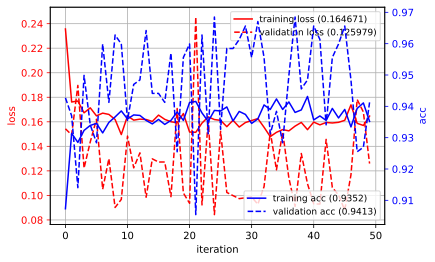

In [25]:
plot_history(history)
predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

Using data augmentation, the test accuracy improves from 0.622 to 0.692!

Now train your best CNN from the previous section using data augmentation. 
Try different per-pixel noise levels, and different options of the ImageDataGenerator (see [here](https://keras.io/preprocessing/image/)), 
and combinations of them.  Hopefully you should be able to improve the accuracy! 

### 5-layer CNN model with augmentation add_gauss_noise()

In [26]:
nn = Sequential()
nn.add(Conv2D(10, (5,5),strides=(2,2), activation='relu', padding='same', input_shape=(19,19,1)))
nn.add(Conv2D(40, (5,5),strides=(2,2), activation='relu', padding='same'))
nn.add(Dropout(rate=0.5, seed=44))
nn.add(Flatten())
nn.add(Dense(units=50, activation='relu'))
nn.add(Dense(units=2, activation='softmax'))

nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 10, 10, 10)        260       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 40)          10040     
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 40)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                50050     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 102       
Total params: 60,452
Trainable params: 60,452
Non-trainable params: 0
__________________________________________________

In [27]:
# lr=1e-2, momentum=0.9

# addNoise 1: 0.04, acc = 0.825
# addNoise 2: 0.08, acc = 0.851
# addNoise 3: 0.12, acc = 0.837
# addNoise 4: 0.20, acc = 0.865

def addNoise(X):
#     return add_gauss_noise(X, 0.04)
#     return add_gauss_noise(X, 0.08)
#     return add_gauss_noise(X, 0.12)
    return add_gauss_noise(X, 0.20)

# data augmenter 1
datagen = ImageDataGenerator(
    rotation_range=10,         # image rotation
    width_shift_range=0.05,     # image shifting
    height_shift_range=0.05,    # image shifting
    shear_range=0.05,           # shear transformation
    zoom_range=0.05,            # zooming
    horizontal_flip=True,       # horizontal flipping
    preprocessing_function=addNoise,  # add per-pixel noise
    data_format='channels_last')

In [28]:
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, mode='auto')
callbacks_list = [earlystop]

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy, 
           optimizer=keras.optimizers.SGD(lr=1e-2, momentum=0.9, nesterov=True), 
           metrics=['accuracy'])

history = nn.fit_generator(datagen.flow(vtrainI, vtrainYb, batch_size=64),
                           steps_per_epoch=len(vtrainI)/64, epochs=100,
                           callbacks=callbacks_list, 
                           validation_data=validsetI, verbose=False)

Epoch 00026: early stopping


test accuracy: 0.8315677966101694


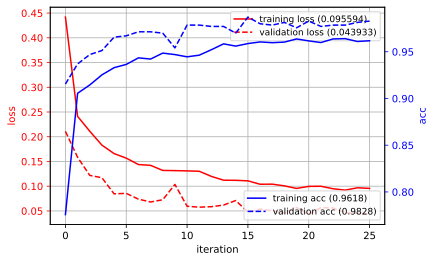

In [29]:
plot_history(history)
predY = nn.predict_classes(testI, verbose=False)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

### 5-layer CNN model with augmentation add_corrupt_noise()

In [30]:
nn = Sequential()
nn.add(Conv2D(10, (5,5),strides=(2,2), activation='relu', padding='same', input_shape=(19,19,1)))
nn.add(Conv2D(40, (5,5),strides=(2,2), activation='relu', padding='same'))
nn.add(Dropout(rate=0.5, seed=44))
nn.add(Flatten())
nn.add(Dense(units=50, activation='relu'))
nn.add(Dense(units=2, activation='softmax'))

nn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 10, 10, 10)        260       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 40)          10040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 40)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                50050     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 102       
Total params: 60,452
Trainable params: 60,452
Non-trainable params: 0
__________________________________________________

In [31]:
# lr=1e-2, momentum=0.9

# addNoise 1: 0.1, acc = 0.856
# addNoise 2: 0.2, acc = 0.868
# addNoise 3: 0.5, acc = 0.810

# build the noise function
def addNoise(X):
#     return add_corrupt_noise(X, p=0.1)
    return add_corrupt_noise(X, p=0.2)
#     return add_corrupt_noise(X, p=0.5)

# build the data augmenter
datagen = ImageDataGenerator(
    rotation_range=10,         # image rotation
    width_shift_range=0.05,     # image shifting
    height_shift_range=0.05,    # image shifting
    shear_range=0.05,           # shear transformation
    zoom_range=0.05,            # zooming
    horizontal_flip=True,       # horizontal flipping
    preprocessing_function=addNoise,  # add per-pixel noise
    data_format='channels_last')

In [32]:
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, mode='auto')
callbacks_list = [earlystop]

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy, 
           optimizer=keras.optimizers.SGD(lr=1e-2, momentum=0.9, nesterov=True), 
           metrics=['accuracy'])

history = nn.fit_generator(datagen.flow(vtrainI, vtrainYb, batch_size=64),
                           steps_per_epoch=len(vtrainI)/64, epochs=100,
                           callbacks=callbacks_list, 
                           validation_data=validsetI, verbose=False)

Epoch 00020: early stopping


test accuracy: 0.8802966101694916


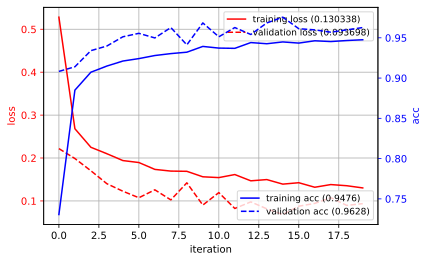

In [33]:
plot_history(history)
predY = nn.predict_classes(testI, verbose=False)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

### 5-layer CNN model with augmentation add_scale_shift()

In [34]:
nn = Sequential()
nn.add(Conv2D(10, (5,5),strides=(2,2), activation='relu', padding='same', input_shape=(19,19,1)))
nn.add(Conv2D(40, (5,5),strides=(2,2), activation='relu', padding='same'))
nn.add(Dropout(rate=0.5, seed=44))
nn.add(Flatten())
nn.add(Dense(units=50, activation='relu'))
nn.add(Dense(units=2, activation='softmax'))

nn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 10, 10, 10)        260       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 5, 40)          10040     
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 40)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                50050     
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 102       
Total params: 60,452
Trainable params: 60,452
Non-trainable params: 0
__________________________________________________

In [35]:
# lr=1e-2, momentum=0.9

# addNoise 1: 0.1, 0.2, acc = 0.831
# addNoise 2: 0.5, 0.5, acc = 0.805

# build the noise function
def addNoise(X):
#     return add_scale_shift(X, sigma2=0.1, alpha2=0.2)
    return add_scale_shift(X, sigma2=0.5, alpha2=0.5)

# build the data augmenter
datagen = ImageDataGenerator(
    rotation_range=10,         # image rotation
    width_shift_range=0.05,     # image shifting
    height_shift_range=0.05,    # image shifting
    shear_range=0.05,           # shear transformation
    zoom_range=0.05,            # zooming
    horizontal_flip=True,       # horizontal flipping
    preprocessing_function=addNoise,  # add per-pixel noise
    data_format='channels_last')

In [36]:
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, mode='auto')
callbacks_list = [earlystop]

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy, 
           optimizer=keras.optimizers.SGD(lr=1e-2, momentum=0.9, nesterov=True), 
           metrics=['accuracy'])

history = nn.fit_generator(datagen.flow(vtrainI, vtrainYb, batch_size=64),
                           steps_per_epoch=len(vtrainI)/64, epochs=100,
                           callbacks=callbacks_list, 
                           validation_data=validsetI, verbose=False)

Epoch 00031: early stopping


test accuracy: 0.8209745762711864


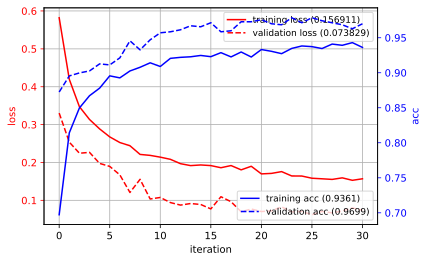

In [37]:
plot_history(history)
predY = nn.predict_classes(testI, verbose=False)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

### How does CNN with data augmentation compare with your work in Tutorial 8?

1. In toturial 8, the highest test accuracy I obtained was 0.793 using add_scale_shift(sigma2=0.1, alpha2=0.2); In toturial 9, the highest test accuracy I obtained was 0.868 using add_corrupt_noise(X, p=0.2).

2. In Tutorial 8, after using augmentation, the test accuracy of MLP model is improved from around 0.70 to around 0.78; In Tutorial 9, after using augmentation, the test accuracy of CNN model is improved from around 0.78 to around 0.88.

3. Among the 3 types of augmentation methods, the add_corrupt_noise() can help the CNN model to achieve higher test accuracy.

4. In summary, data augmentation worked better when data is fed to the CNN model (encourages the model to converge faster and achieve higher test accuracy). Compared with T8, we do much better now.

# Test image
Now lets try your face detector on a real image.  Download the "nasa-small.png" image and put it in the same directory as your ipynb file.  The below code will load the image, crop out image patches and then extract features. (this may take a few minutes)

In [38]:
fname = "nasa-small.png"

(210, 480)


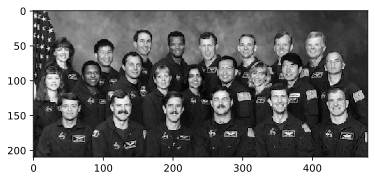

In [39]:
# load image
testimg3 = skimage.io.imread(fname)

# convert to grayscale
testimg = skimage.color.rgb2gray(testimg3)
print(testimg.shape)
plt.imshow(testimg, cmap='gray')

In [40]:
# step size for the sliding window
step = 4

# extract window patches with step size of 4
patches = skimage.util.view_as_windows(testimg, (19,19), step=step)
psize = patches.shape
# collapse the first 2 dimensions
patches2 = patches.reshape((psize[0]*psize[1], psize[2], psize[3], 1))
print(patches2.shape)

# histogram equalize patches (improves contrast)
newI = empty(patches2.shape)
for i in range(patches2.shape[0]):
    newI[i,:,:] = skimage.exposure.equalize_hist(patches2[i,:,:])
# newI = patches2

(5568, 19, 19, 1)


/opt/anaconda3/lib/python3.7/site-packages/skimage/exposure/exposure.py:124: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


Now predict using your classifier.  The extracted images are in `newI`.

In [46]:
# prednewY = argmax(nn.predict(newI), axis=-1)

preY = nn.predict_proba(newI)

for i in range(len(preY)):
    preY[i][0] *= 10

prednewY = argmax(preY, axis=-1)

Now we we will view the results on the image.  Use the below code. `prednewY` is the vector of predictions.

(-0.5, 479.5, 209.5, -0.5)

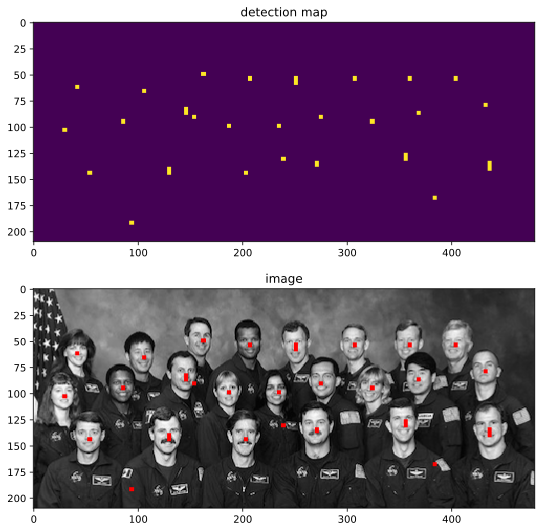

In [47]:
# reshape prediction to an image
imgY = prednewY.reshape(psize[0], psize[1])

# zoom back to image size
imgY2 = ndimage.interpolation.zoom(imgY, step, output=None, order=0)
# pad the top and left with half the window size
imgY2 = vstack((zeros((9, imgY2.shape[1])), imgY2))
imgY2 = hstack((zeros((imgY2.shape[0],9)), imgY2))
# pad right and bottom to same size as image
if (imgY2.shape[0] != testimg.shape[0]):
    imgY2 = vstack((imgY2, zeros((testimg.shape[0]-imgY2.shape[0], imgY2.shape[1]))))
if (imgY2.shape[1] != testimg.shape[1]):
    imgY2 = hstack((imgY2, zeros((imgY2.shape[0],testimg.shape[1]-imgY2.shape[1]))))
    
# show detections with image
#detimg = dstack(((0.5*imgY2+0.5)*testimg, 0.5*testimg, 0.5*testimg))
nimgY2 = 1-imgY2
tmp = nimgY2*testimg
detimg = dstack((imgY2+tmp, tmp, tmp))

# show it!
plt.figure(figsize=(9,9))
plt.subplot(2,1,1)
plt.imshow(imgY2, interpolation='nearest')
plt.title('detection map')
plt.subplot(2,1,2)
plt.imshow(detimg)
plt.title('image')
plt.axis('image')

### How did your face detector do compared to the last version?

The CNN face detector model I trained in Toturial 9 outperformed the models traiend in Tutorial 4&8. Reasons are as follow:

0. Note: I changed the prediction threshold to reduce the false positive and it worked pretty well:

> preY = nn.predict_proba(newI)\
> for i in range(len(preY)):\
> ^^preY\[i\]\[0\] *= 10 \
> prednewY = argmax(preY, axis=-1)

1. The CNN model will not recognize the chest label as human face (much lower false positive rate).

2. The CNN model correctly recognize all the human faces (much higher true positive rate).

3. The CNN gives a higher accuracy.

4. Below I tried on several group photos, the performance is quite satisfing.

You can try it on your own images.  The faces should all be around 19x19 pixels though. We only used 1/8 of the training data. Try using more data to train it!

In [ ]:
# fname1 = "mine_f.png"

# # load image
# testimg1 = skimage.io.imread(fname1)

# # convert to grayscale
# testimg2 = skimage.color.rgb2gray(testimg1)
# print(testimg2.shape)
# plt.imshow(testimg2, cmap='gray')

# def func(testimg):
#     # step size for the sliding window
#     step = 4

#     # extract window patches with step size of 4
#     patches = skimage.util.view_as_windows(testimg, (19,19), step=step)
#     psize = patches.shape
#     # collapse the first 2 dimensions
#     patches2 = patches.reshape((psize[0]*psize[1], psize[2], psize[3]))
#     print(patches2.shape)

#     # histogram equalize patches (improves contrast)
#     patches3 = empty(patches2.shape)
#     for i in range(patches2.shape[0]):
#         patches3[i,:,:] = skimage.exposure.equalize_hist(patches2[i,:,:])

#     # extract features
#     newXf = extract_features(patches3)
    
#     return newXf

# def fun2(prednewY, testimg):
#     # reshape prediction to an image
#     imgY = prednewY.reshape(psize[0], psize[1])

#     # zoom back to image size
#     imgY2 = ndimage.interpolation.zoom(imgY, step, output=None, order=0)
#     # pad the top and left with half the window size
#     imgY2 = vstack((zeros((9, imgY2.shape[1])), imgY2))
#     imgY2 = hstack((zeros((imgY2.shape[0],9)), imgY2))
#     # pad right and bottom to same size as image
#     if (imgY2.shape[0] != testimg.shape[0]):
#         imgY2 = vstack((imgY2, zeros((testimg.shape[0]-imgY2.shape[0], imgY2.shape[1]))))
#     if (imgY2.shape[1] != testimg.shape[1]):
#         imgY2 = hstack((imgY2, zeros((imgY2.shape[0],testimg.shape[1]-imgY2.shape[1]))))
    
    
#     nimgY2 = 1-imgY2
#     tmp = nimgY2*testimg
#     detimg = dstack((imgY2+tmp, tmp, tmp))

#     # show it!
#     plt.figure(figsize=(9,9))
#     plt.subplot(2,1,1)
#     plt.imshow(imgY2, interpolation='nearest')
#     plt.title('detection map')
#     plt.subplot(2,1,2)
#     plt.imshow(detimg)
#     plt.title('image')
#     plt.axis('image')

# print(newXf2=func(testimg2))
# newXfn2  = scalerf.transform(newXf2)        # apply scaling to test data
# prednewY = nn.predict_classes(newI)
# func2(prednewY1, testimg)